# Analysis for the Recovery System

Okay, for the most part, this isn't analyzing drag for the recovery system yet, lol. Most of it is looking at the OpenRocket outputs and comparing them to DATCOM. In fact, this will probably get blobbed together as some omni-analysis for LV3 at some point. 

## Read in data; Sanity check on where/what

In [1]:
getwd()
openRocketCSV <- "simData/LV3_L13_ideal_2017-5-30-1804.csv"
dat <- read.csv(openRocketCSV, skip=6)
datNames <- names(dat)
dat <- read.table(openRocketCSV, header= F, sep=',')
names(dat) <- datNames
head(dat)

# Print out the event lines from the CSV:
# system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv', intern = TRUE)
events <- as.numeric(system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv | grep -o \'[0-9]\\+\\.*[0-9]*\'', intern = TRUE))
events.names <- system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv | grep -o \'[[:upper:]_]\\{2,\\}\'', intern = TRUE)
names(events) <- events.names
events

[1] "/home/joedang/git/PSAS/lv3.0-airframe/sim"

X..Time..s.,Altitude..km.,Vertical.velocity..m.s.,Vertical.acceleration..m.s..,Total.velocity..m.s.,Total.acceleration..m.s..,Position.East.of.launch..km.,Position.North.of.launch..km.,Lateral.distance..km.,Lateral.direction....,⋯,Reference.length..in.,Reference.area..m..,Vertical.orientation..zenith.....,Lateral.orientation..azimuth.....,Wind.velocity..m.s.,Air.temperature...C.,Air.pressure..Pa.,Speed.of.sound..m.s.,Simulation.time.step..s.,Computation.time..s.
0.000,0.0000e+00,0.0000000,-6.85450,0.0000000,6.85450,0,0,0,0,⋯,6.6,0.022072,90,0,NaN,6.03,85832,334.95,0.002,0.0039094
0.002,0.0000e+00,0.0000000,-0.96259,0.0000000,0.96259,0,0,0,0,⋯,6.6,0.022072,90,0,NaN,6.03,85832,334.95,0.002,0.0064070
0.004,0.0000e+00,0.0000000,4.93030,0.0000000,4.93030,0,0,0,0,⋯,6.6,0.022072,90,0,NaN,6.03,85832,334.95,0.002,0.0098882
0.006,9.8618e-09,0.0098621,10.82400,0.0098621,10.82400,0,0,0,0,⋯,6.6,0.022072,90,0,NaN,6.03,85832,334.95,0.002,0.0113170
0.008,5.1236e-08,0.0315120,16.71800,0.0315120,16.71800,0,0,0,0,⋯,6.6,0.022072,90,0,NaN,6.03,85832,334.95,0.002,0.0128110
0.010,1.4770e-07,0.0649510,22.61300,0.0649510,22.61300,0,0,0,0,⋯,6.6,0.022072,90,0,NaN,6.03,85832,334.95,0.002,0.0142590


LAUNCH                   IGNITION 
                    0.0000                     0.0000 
                   LIFTOFF                  LAUNCHROD 
                    0.0380                     0.2800 
                   BURNOUT            EJECTION_CHARGE 
                    6.3242                     6.3242 
                    APOGEE RECOVERY_DEVICE_DEPLOYMENT 
                   34.8340                    35.3340 
RECOVERY_DEVICE_DEPLOYMENT                 GROUND_HIT 
                  217.7500                   250.6100 
            SIMULATION_END 
                  250.6100

In [2]:
# Print out the event lines from the CSV:
# system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv', intern = TRUE)
events <- as.numeric(system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv | grep -o \'[0-9]\\+\\.*[0-9]*\'', intern = TRUE))
events.names <- system('grep \'occur\' simData/LV3_L13_ideal_2017-5-30-1804.csv | grep -o \'[[:upper:]_]\\{2,\\}\'', intern = TRUE)
names(events) <- events.names
# events

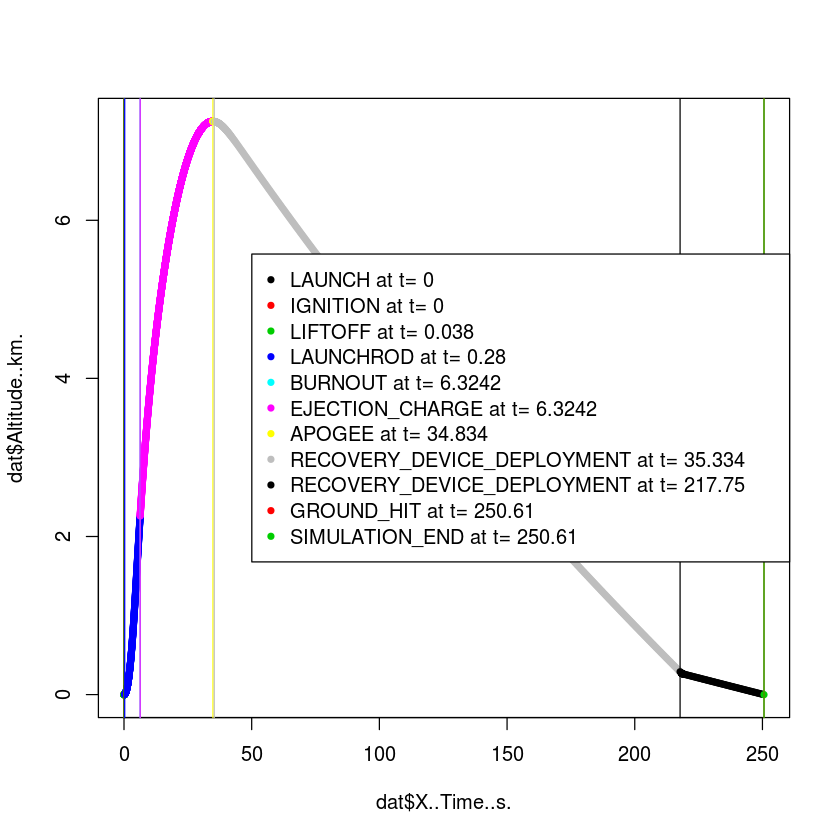

In [3]:
dat$colors <- sapply(dat$X..Time..s., function(t) sum(t>=events))
# layout(mat = matrix(c(1,2), nrow = 1))
plot(dat$X..Time..s., dat$Altitude..km., col=dat$colors, pch=20)
abline(v=events, col=1:length(events))
# text(
#     labels=names(events),
#     x=events,
#     y=seq(from=0, to=max(dat$Alt), length.out=length(events)),
#     col=1:length(events),
#     pos=4, srt=0, offset=-0.0
# )
legend(
    'right',
    legend=paste(names(events), 'at t=', events),
    col=1:length(events),
    pch=20
)

In [4]:
ind <- which(
    dat$X..Time..s. > events['LAUNCHROD'] 
    & dat$X..Time..s. < events['APOGEE'] +2
)
launchlim <- range(dat$X..Time..s.[ind])

## Drag Calculations

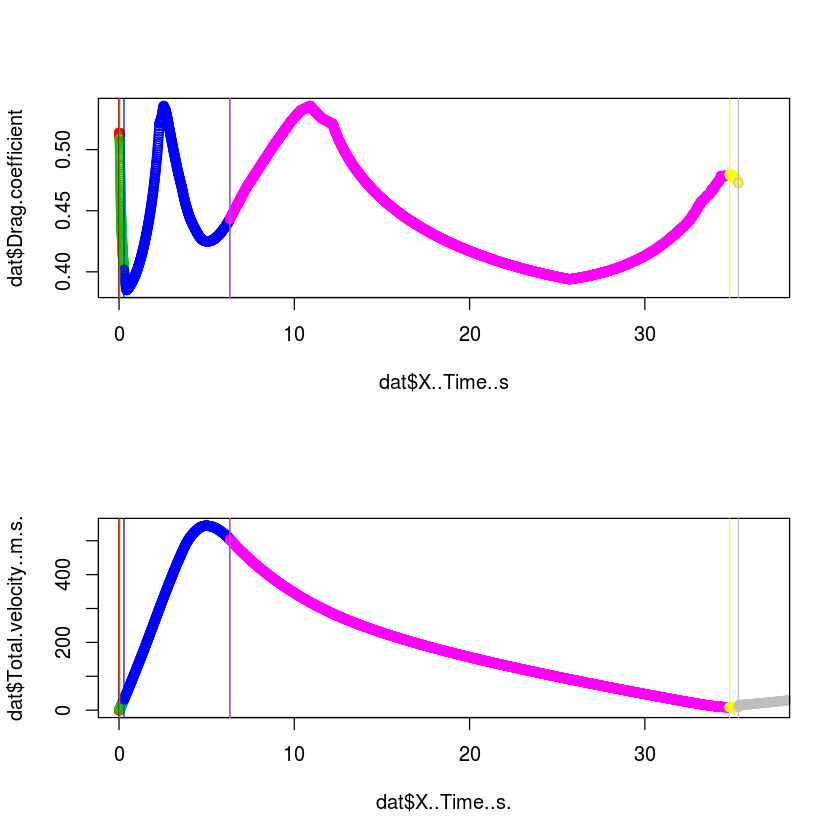

In [5]:
layout(matrix(c(1,2),nrow= 2))
plot(dat$X..Time..s, dat$Drag.coefficient, col=dat$col, xlim=launchlim)
abline(v=events, col=1:length(events))
plot(dat$X..Time..s., dat$Total.velocity..m.s., col=dat$col, xlim=launchlim)
abline(v=events, col=1:length(events))

## DATCOM comparisons

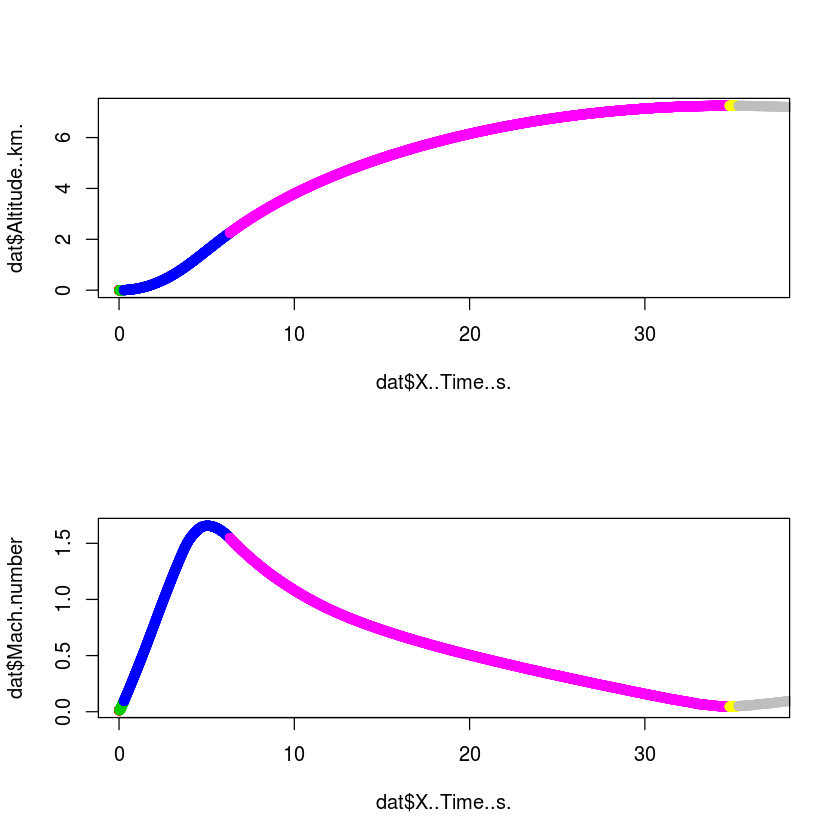

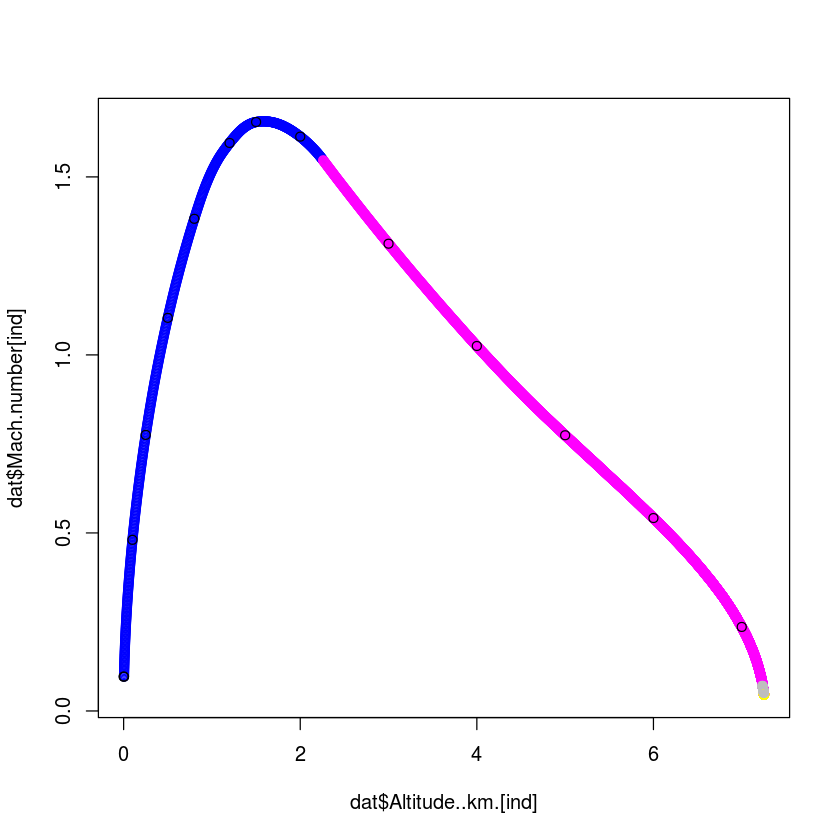

In [6]:
rodAlt <- dat$Altitude..km.[which(dat$X..Time..s.==events['LAUNCHROD'])]
schedule.alt.mach <- approx( # sample some altitude/mach number pairs with linear interpolation
    dat$Alt[ind], dat$Mach[ind], 
    xout=c(0,rodAlt,0.1,0.25,0.5,0.8,1.2,1.5,2,3,4,5,6,7), 
    rule=2
)
alt.schedule <- schedule.alt.mach$x
mach.schedule <- schedule.alt.mach$y
alt.schedule.inch <- alt.schedule*1e6/25.4 #convert from km into in

layout(matrix(c(1,2), nrow=2))
plot(dat$X..Time..s., dat$Altitude..km., xlim=launchlim, col=dat$col)
plot(dat$X..Time..s., dat$Mach.number, xlim=launchlim, col=dat$col)
layout(1)
plot(dat$Altitude..km.[ind], dat$Mach.number[ind], col=dat$col[ind])
points(alt.schedule, mach.schedule)

### inputs for altitude schedule and Mach schedule:

In [7]:
# DATCOM-friendly output:
cat('##### INSERT THESE INTO THE DATCOM INPUT FILE: #####\n')
cat('ALSCHD:\n')
cat(toupper(format(alt.schedule.inch, scientific = T, digits=2)),sep=',')
cat('\nMACH:\n')
cat(toupper(format(mach.schedule, scientific = T, digits=2)),sep=',')

##### INSERT THESE INTO THE DATCOM INPUT FILE: #####
ALSCHD:
0.0E+00,1.6E+02,3.9E+03,9.8E+03,2.0E+04,3.1E+04,4.7E+04,5.9E+04,7.9E+04,1.2E+05,1.6E+05,2.0E+05,2.4E+05,2.8E+05
MACH:
9.6E-02,9.6E-02,4.8E-01,7.8E-01,1.1E+00,1.4E+00,1.6E+00,1.7E+00,1.6E+00,1.3E+00,1.0E+00,7.7E-01,5.4E-01,2.4E-01